# Linear Discriminants: logistic regression

$\newcommand{\x}{\mathbf{x}}\newcommand{\w}{\mathbf{w}}\newcommand{\c}{\mathcal{C}}$

As we have seen in the lecture, the logistic regression models the probability of a class label $\c$ given a datapoint $p(\c|\x)$ as:
$$p(\c|\x) = \sigma(\w^\top\x) = \frac{1}{1+e^{-\w^\top\x}}$$

In this lab, we shall implement this model.

## Logistic function

To get started, let us plot the logistic function $\sigma(a)$ in the range $[-5\dots 5]$ in blue, and its derivative $\frac{\partial}{\partial a} \sigma(a)$ in green.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import time
from IPython import display

xx,yy = np.mgrid[-5:10:.5,-5:10:.5]

def plotHeat(w):
    """ 
    Plot a weight vector w = [w_0,w_1,w_2] as a colour map
    """
    display.clear_output(wait=True)
    display.display(plt.gcf())
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = sigma(w.dot(np.array([1., xx[i,j], yy[i,j]])))
    plt.pcolor(xx,yy,p,cmap='seismic')
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.scatter(d[:,0],d[:,1],20,colours)
    time.sleep(.01)


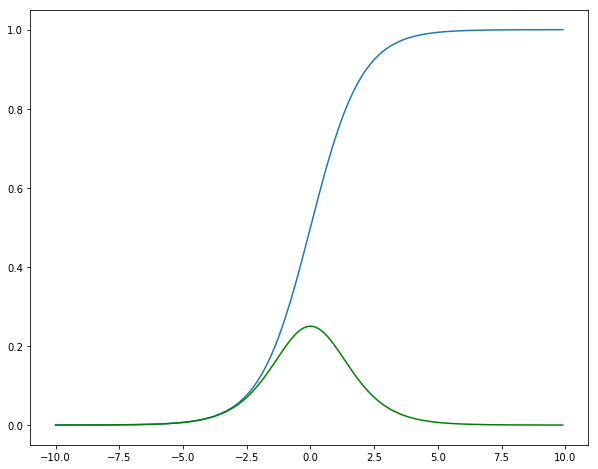

In [3]:
x = np.arange(-10,10,.1)
def sigma(a):
    return 1./(1.+np.exp(-a))

plt.plot(x,sigma(x))
plt.plot(x,sigma(x)*(1-sigma(x)),'g')

## Training data

Next, load the data in the provided data file "*data-2class.npz*", and plot it. Then also plot the discriminant of a logistic regression model with parameters $\w = [ 0,1,1]$.


$\frac{1}{1+e^{-\w^\top\x}} = 1/2$, so $\exp \w^\top \x = 1$ or $\w^\top\x = 0$. In other words, we can plot 
$w_0+w_1x_1 + w_2x_2 = 0$, or $x_1 = -\frac{w_2x_2+w_0}{w_1}$

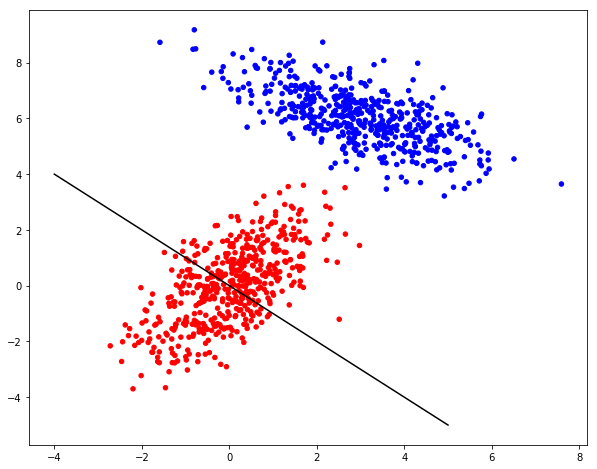

In [5]:
data = np.load("data-2class.npz")
d = data['d']
l = data['l']

colours = [ [ 'r', 'b' ][int(x)] for x in np.nditer(l)]
plt.scatter(d[:,0],d[:,1],20,colours)

def plotDisc(w):
    if abs(w[1])>abs(w[2]):
        yr = np.arange(-6,10,1)
        xr = -(w[2]*yr+w[0])/w[1]
        valid  = (xr>-4) & (xr<10)
        plt.plot(xr[valid], yr[valid],'k')
    else:
        xr = np.arange(-4,10,1)
        yr = -(w[1]*xr+w[0])/w[2]
        valid  = (yr>-6) & (yr<10)
        plt.plot(xr[valid], yr[valid],'k')

plotDisc([0,1.,1.])

## Probability of the given labels for all datapoints

We will now train our logistic regression model on a training dataset. This dataset contains a number of datapoints $\x_1,\dots,\x_N$belonging to two classes and, for each datapoint $\x_n$, the corresponding class label $l_n$. The training is done by *maximum likelihood*, that is, we maximise the probability of the data given the model. 

## Model

Before we start coding, let's have a closer look at the model. Our labels are $0$ or $1$, representing the two classes. If a datapoint $\x_n$ belongs to class $\c_n=1$, the probability $p(\c_n=1|\x_n) = \sigma(\w^\top\x_n)$ and the probability $p(\c_n=0|\x_n) = 1-\sigma(\w^\top\x)$. We now want the probability of the labels given the data, for the complete training set: $p(\c_1,\dots,\c_N|\x_1,\dots,\x_N)$. Remember that the probability of the union of two independent events is $p(a,b)=p(a)\,p(b)$. Using the fact that the labels are $0$ and $1$ (and that $x^0=1$ and $x^1=x$, we can then write this as 
$$p(\c_1\dots\c_n|\x_1\dots\x_n,\w) = \prod_{n=1}^N \sigma(\w^\top\x_n)^{\c_n}\,(1-\sigma(\w^\top\x_n))^{1-\c_n}$$

**Question 1 [5 Marks]:** For the provided dataset, compute this probability when the model weights are $\w = [ 0,-1,-1]$
Think about how you could find the maximum of this function. What does the gradient of this probability look like?

In [6]:
def sigma(a):
    return 1./(1.+np.exp(-a))

prob = 1.
w = np.array([0,-1,-1])
#extend the data with a 1 in column 0
v = np.ones((d.shape[0],d.shape[1]+1))
v[:,1:] = d
sig = 0
for x,c in zip(v,l):
    sig = sigma(w.dot(np.array([1., x[1], x[2]])))
    prob *= sig**c * sig**(1-c)
print "probability is: ", prob


probability is:  [ 0.]


Dealing with the joint probability is complicated, as 1) its value can become very small, easily too small for a computer to represent it accurately, and 2) taking the gradient of this joint probability with respect to $\w$ makes the contribution of every datapoint to the gradient depend on every other datapoint's value.

# Gradient

So instead, we will define an error function which is the natural logarithm of the likelihood: 

\begin{align}
\newcommand{\wx}{\mathbf{w}^\top\x}
E(\w) &\triangleq -\log p(\c_1,\dots,\c_N|\x_1,\dots,\x_N)\\
&= -\sum_n \c_n\log \frac{1}{1+e^{-\wx}} + (1-\c_n) \log (1-\frac{1}{1+e^{-\wx}}) \\
&= \sum_n \c_n \log (1+e^{-\wx}) - (1-\c_n) \log \frac{1+e^{-\wx}-1}{1+e^{-\wx}} \\
&= \sum_n \c_n \log (1+e^{-\wx}) - (1-\c_n) (-\wx - \log(1+e^{-\wx})) \\ 
&= \sum_n \c_n \log (1+e^{-\wx}) + \wx + \log(1+e^{-\wx}) - \c_n\wx - \c_n \log(1+e^{-\wx}) \\
&= \sum_n (1-\c_n)\wx + \log(1+e^{-\wx})
\end{align}



**Question 2 [5 marks]:** Compute the actual value of the error function for the given dataset and weight $w=[0,-1,-1]$.

Notice that this function does not contain products of probabilities anymore, thus making the derivative of the joint probability with respect of each of the weights a sum of derivatives of the probabilities of single datapoints. The logarithm is what's called a "monotonically increasing function", which means that if $x_1 > x_2$, $f(x_1) > f(x_2)$. Because of that, the value of $\w$ for which $p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is maximal is also the value of $\w$ for which $\log p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is maximal and thus $-\log p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is minimal.


In [7]:
prob = 1.
def errorfunction(w):
    #extend the data with a 1 in column 0
    v = np.ones((d.shape[0],d.shape[1]+1))
    v[:,1:] = d
    som = 0
    for x,c in zip(v,l):
        wdotx = w.dot(np.array([1., x[1], x[2]]))
        sig = sigma(w.dot(np.array([1., x[1], x[2]])))
        som += (1-c)*wdotx + np.log(1 + np.exp(-1*wdotx))
    return som
print "probability is: ", errorfunction(np.array([0,-1,-1]))

probability is:  [ 5056.86191856]


**Question 3 [30 marks]:** Implement gradient descent, updating the weights as $\w^{\mathrm{new}} = \w^{\mathrm{old}} - \eta \nabla_\w E(\w)$. The value of $\eta$ will affect how fast the algorithm converges and is really up to you. In this case, I suggest you use $\eta=10^{-3}$, which is quite small but allows you to see what's happening. This is a form of batch gradient descent. 

The gradient of $\nabla_\w E(\w)$ is given by $\nabla_\w E(\w) = \sum_{n=1}^N \left(\sigma( \w^\top\x_n)-\c_n\right)\x_n$

\begin{align}
\nabla_\w E(\w) &= \sum (1-\c)\x + \frac{1}{1+e^{-\wx}}e^{-\wx}(-\x)\\
&=(1-\c-1+\sigma(\wx))\x
\end{align}


Protip: use the "plotheat" function defined above to plot what the classifier looks like at each iteration. This will allow you to visualise how the optimisation is doing.

In [8]:
# Answer to Q4
def calcgradientbatch():
    eta = 10**-3

    w = np.array([0,-1,-1])
    #extend the data with a 1 in column 0
    v = np.ones((d.shape[0],d.shape[1]+1))
    v[:,1:] = d
    count = 0
    notimprovedfor = 0
    besterror = 1000000
    bestw = w
    while notimprovedfor < 20:
        error = errorfunction(w)
        print error
        if error[0] >= besterror - 0.01:
            notimprovedfor += 1
        else:
            besterror = error[0]
            notimprovedfor = 0
            bestw = w
        misclassified = 0
        gradient = 0
        for x,c in zip(v,l):
            gradient += (1-c[0]-1 + sigma(w.dot(x))) * x
            misclassified += 1
        w = w - eta * gradient
        count += 1

    print bestw
    print count
    
%time calcgradientbatch()


[ 5056.86191856]
[ 877.80412942]
[ 723.48610749]
[ 582.2186208]
[ 457.44065597]
[ 353.09183337]
[ 273.75666604]
[ 224.4883914]
[ 202.09624927]
[ 188.88376999]
[ 177.59094817]
[ 167.74970489]
[ 159.10005464]
[ 151.43866961]
[ 144.60460783]
[ 138.46925319]
[ 132.92887274]
[ 127.89905135]
[ 123.31050261]
[ 119.10589118]
[ 115.23740285]
[ 111.66487129]
[ 108.35432185]
[ 105.27683065]
[ 102.40762367]
[ 99.72535979]
[ 97.21155631]
[ 94.85012519]
[ 92.62699634]
[ 90.52980945]
[ 88.54766065]
[ 86.67089268]
[ 84.89092048]
[ 83.20008515]
[ 81.59153127]
[ 80.05910325]
[ 78.59725734]
[ 77.20098669]
[ 75.86575719]
[ 74.58745232]
[ 73.36232561]
[ 72.18695952]
[ 71.05822963]
[ 69.97327353]
[ 68.92946358]
[ 67.92438299]
[ 66.95580487]
[ 66.02167366]
[ 65.12008877]
[ 64.24929005]
[ 63.40764491]
[ 62.5936368]
[ 61.80585492]
[ 61.04298511]
[ 60.30380153]
[ 59.58715933]
[ 58.89198794]
[ 58.21728507]
[ 57.5621113]
[ 56.92558515]
[ 56.3068786]
[ 55.70521309]
[ 55.11985581]
[ 54.55011631]
[ 53.99534352]
[ 53

[ 14.29207342]
[ 14.27693917]
[ 14.26184982]
[ 14.24680514]
[ 14.23180493]
[ 14.21684896]
[ 14.20193703]
[ 14.18706893]
[ 14.17224444]
[ 14.15746336]
[ 14.14272549]
[ 14.12803061]
[ 14.11337854]
[ 14.09876905]
[ 14.08420196]
[ 14.06967706]
[ 14.05519416]
[ 14.04075305]
[ 14.02635355]
[ 14.01199545]
[ 13.99767857]
[ 13.98340272]
[ 13.96916769]
[ 13.95497331]
[ 13.94081939]
[ 13.92670573]
[ 13.91263215]
[ 13.89859847]
[ 13.88460451]
[ 13.87065008]
[ 13.856735]
[ 13.84285908]
[ 13.82902216]
[ 13.81522406]
[ 13.80146459]
[ 13.78774358]
[ 13.77406087]
[ 13.76041626]
[ 13.7468096]
[ 13.7332407]
[ 13.71970941]
[ 13.70621555]
[ 13.69275896]
[ 13.67933946]
[ 13.66595689]
[ 13.65261108]
[ 13.63930188]
[ 13.62602912]
[ 13.61279263]
[ 13.59959226]
[ 13.58642785]
[ 13.57329923]
[ 13.56020626]
[ 13.54714877]
[ 13.5341266]
[ 13.5211396]
[ 13.50818762]
[ 13.49527051]
[ 13.48238811]
[ 13.46954026]
[ 13.45672683]
[ 13.44394766]
[ 13.4312026]
[ 13.4184915]
[ 13.40581422]
[ 13.39317061]
[ 13.38056053]
[ 1

[ 9.56966997]
[ 9.56481558]
[ 9.55996826]
[ 9.55512797]
[ 9.55029469]
[ 9.54546843]
[ 9.54064915]
[ 9.53583684]
[ 9.53103148]
[ 9.52623306]
[ 9.52144156]
[ 9.51665697]
[ 9.51187926]
[ 9.50710843]
[ 9.50234445]
[ 9.49758732]
[ 9.49283701]
[ 9.4880935]
[ 9.48335679]
[ 9.47862685]
[ 9.47390368]
[ 9.46918725]
[ 9.46447755]
[ 9.45977456]
[ 9.45507827]
[ 9.45038867]
[ 9.44570573]
[ 9.44102944]
[ 9.43635979]
[ 9.43169675]
[ 9.42704033]
[ 9.42239049]
[ 9.41774723]
[ 9.41311052]
[ 9.40848036]
[ 9.40385673]
[ 9.39923962]
[ 9.394629]
[ 9.39002487]
[ 9.38542721]
[ 9.380836]
[ 9.37625124]
[ 9.37167289]
[ 9.36710096]
[ 9.36253543]
[ 9.35797627]
[ 9.35342349]
[ 9.34887705]
[ 9.34433695]
[ 9.33980318]
[ 9.33527571]
[ 9.33075454]
[ 9.32623965]
[ 9.32173102]
[ 9.31722865]
[ 9.31273252]
[ 9.30824261]
[ 9.3037589]
[ 9.2992814]
[ 9.29481007]
[ 9.29034491]
[ 9.28588591]
[ 9.28143305]
[ 9.27698631]
[ 9.27254569]
[ 9.26811116]
[ 9.26368272]
[ 9.25926035]
[ 9.25484403]
[ 9.25043377]
[ 9.24602953]
[ 9.24163131]

[ 7.52879837]
[ 7.5263678]
[ 7.5239395]
[ 7.52151347]
[ 7.51908972]
[ 7.51666823]
[ 7.514249]
[ 7.51183204]
[ 7.50941732]
[ 7.50700487]
[ 7.50459466]
[ 7.50218669]
[ 7.49978097]
[ 7.49737749]
[ 7.49497624]
[ 7.49257722]
[ 7.49018043]
[ 7.48778587]
[ 7.48539353]
[ 7.4830034]
[ 7.4806155]
[ 7.4782298]
[ 7.47584631]
[ 7.47346503]
[ 7.47108595]
[ 7.46870906]
[ 7.46633438]
[ 7.46396188]
[ 7.46159157]
[ 7.45922345]
[ 7.4568575]
[ 7.45449374]
[ 7.45213215]
[ 7.44977274]
[ 7.44741549]
[ 7.4450604]
[ 7.44270748]
[ 7.44035672]
[ 7.43800812]
[ 7.43566166]
[ 7.43331736]
[ 7.4309752]
[ 7.42863518]
[ 7.4262973]
[ 7.42396156]
[ 7.42162796]
[ 7.41929648]
[ 7.41696713]
[ 7.4146399]
[ 7.41231479]
[ 7.4099918]
[ 7.40767092]
[ 7.40535216]
[ 7.4030355]
[ 7.40072095]
[ 7.3984085]
[ 7.39609814]
[ 7.39378989]
[ 7.39148372]
[ 7.38917964]
[ 7.38687765]
[ 7.38457774]
[ 7.38227992]
[ 7.37998416]
[ 7.37769049]
[ 7.37539888]
[ 7.37310934]
[ 7.37082186]
[ 7.36853645]
[ 7.36625309]
[ 7.36397179]
[ 7.36169254]
[ 7.359

[ 6.38904916]
[ 6.38754286]
[ 6.38603759]
[ 6.38453337]
[ 6.38303018]
[ 6.38152803]
[ 6.38002692]
[ 6.37852684]
[ 6.37702779]
[ 6.37552977]
[ 6.37403278]
[ 6.37253682]
[ 6.37104189]
[ 6.36954798]
[ 6.3680551]
[ 6.36656325]
[ 6.36507241]
[ 6.3635826]
[ 6.36209381]
[ 6.36060604]
[ 6.35911929]
[ 6.35763356]
[ 6.35614884]
[ 6.35466514]
[ 6.35318245]
[ 6.35170077]
[ 6.35022011]
[ 6.34874045]
[ 6.34726181]
[ 6.34578417]
[ 6.34430754]
[ 6.34283192]
[ 6.3413573]
[ 6.33988369]
[ 6.33841108]
[ 6.33693947]
[ 6.33546886]
[ 6.33399924]
[ 6.33253063]
[ 6.33106302]
[ 6.3295964]
[ 6.32813077]
[ 6.32666614]
[ 6.3252025]
[ 6.32373986]
[ 6.3222782]
[ 6.32081754]
[ 6.31935786]
[ 6.31789917]
[ 6.31644146]
[ 6.31498474]
[ 6.313529]
[ 6.31207425]
[ 6.31062048]
[ 6.30916769]
[ 6.30771587]
[ 6.30626504]
[ 6.30481518]
[ 6.30336631]
[ 6.3019184]
[ 6.30047147]
[ 6.29902551]
[ 6.29758053]
[ 6.29613651]
[ 6.29469347]
[ 6.29325139]
[ 6.29181028]
[ 6.29037014]
[ 6.28893097]
[ 6.28749275]
[ 6.28605551]
[ 6.28461922]
[

[ 5.64730296]
[ 5.64625462]
[ 5.64520685]
[ 5.64415965]
[ 5.64311303]
[ 5.64206698]
[ 5.6410215]
[ 5.63997659]
[ 5.63893225]
[ 5.63788848]
[ 5.63684528]
[ 5.63580265]
[ 5.63476058]
[ 5.63371909]
[ 5.63267816]
[ 5.6316378]
[ 5.630598]
[ 5.62955877]
[ 5.62852011]
[ 5.62748201]
[ 5.62644447]
[ 5.6254075]
[ 5.62437109]
[ 5.62333524]
[ 5.62229996]
[ 5.62126523]
[ 5.62023107]
[ 5.61919747]
[ 5.61816443]
[ 5.61713195]
[ 5.61610003]
[ 5.61506866]
[ 5.61403786]
[ 5.61300761]
[ 5.61197792]
[ 5.61094879]
[ 5.60992021]
[ 5.60889219]
[ 5.60786472]
[ 5.60683781]
[ 5.60581145]
[ 5.60478565]
[ 5.6037604]
[ 5.6027357]
[ 5.60171155]
[ 5.60068796]
[ 5.59966492]
[ 5.59864242]
[ 5.59762048]
[ 5.59659909]
[ 5.59557825]
[ 5.59455795]
[ 5.59353821]
[ 5.59251901]
[ 5.59150036]
[ 5.59048226]
[ 5.5894647]
[ 5.58844769]
[ 5.58743122]
[ 5.5864153]
[ 5.58539993]
[ 5.58438509]
[ 5.58337081]
[ 5.58235706]
[ 5.58134386]
[ 5.5803312]
[ 5.57931908]
[ 5.5783075]
[ 5.57729646]
[ 5.57628597]
[ 5.57527601]
[ 5.57426659]
[ 5

[ 5.10888266]
[ 5.10810294]
[ 5.10732356]
[ 5.10654454]
[ 5.10576587]
[ 5.10498755]
[ 5.10420959]
[ 5.10343197]
[ 5.10265471]
[ 5.10187779]
[ 5.10110123]
[ 5.10032502]
[ 5.09954915]
[ 5.09877364]
[ 5.09799847]
[ 5.09722366]
[ 5.09644919]
[ 5.09567507]
[ 5.0949013]
[ 5.09412788]
[ 5.09335481]
[ 5.09258208]
[ 5.0918097]
[ 5.09103767]
[ 5.09026598]
[ 5.08949464]
[ 5.08872365]
[ 5.087953]
[ 5.0871827]
[ 5.08641275]
[ 5.08564314]
[ 5.08487387]
[ 5.08410495]
[ 5.08333638]
[ 5.08256814]
[ 5.08180026]
[ 5.08103271]
[ 5.08026551]
[ 5.07949865]
[ 5.07873214]
[ 5.07796597]
[ 5.07720014]
[ 5.07643465]
[ 5.0756695]
[ 5.0749047]
[ 5.07414024]
[ 5.07337612]
[ 5.07261234]
[ 5.0718489]
[ 5.0710858]
[ 5.07032304]
[ 5.06956062]
[ 5.06879854]
[ 5.0680368]
[ 5.0672754]
[ 5.06651434]
[ 5.06575362]
[ 5.06499323]
[ 5.06423319]
[ 5.06347348]
[ 5.06271411]
[ 5.06195507]
[ 5.06119638]
[ 5.06043802]
[ 5.05968]
[ 5.05892231]
[ 5.05816496]
[ 5.05740795]
[ 5.05665127]
[ 5.05589493]
[ 5.05513892]
[ 5.05438325]
[ 5.05

[ 4.7005079]
[ 4.69989903]
[ 4.69929039]
[ 4.69868198]
[ 4.69807381]
[ 4.69746587]
[ 4.69685817]
[ 4.6962507]
[ 4.69564346]
[ 4.69503646]
[ 4.69442969]
[ 4.69382316]
[ 4.69321686]
[ 4.69261079]
[ 4.69200495]
[ 4.69139935]
[ 4.69079398]
[ 4.69018884]
[ 4.68958393]
[ 4.68897926]
[ 4.68837481]
[ 4.6877706]
[ 4.68716663]
[ 4.68656288]
[ 4.68595936]
[ 4.68535608]
[ 4.68475302]
[ 4.6841502]
[ 4.68354761]
[ 4.68294525]
[ 4.68234312]
[ 4.68174122]
[ 4.68113955]
[ 4.68053811]
[ 4.6799369]
[ 4.67933592]
[ 4.67873517]
[ 4.67813465]
[ 4.67753436]
[ 4.67693429]
[ 4.67633446]
[ 4.67573486]
[ 4.67513548]
[ 4.67453633]
[ 4.67393742]
[ 4.67333873]
[ 4.67274026]
[ 4.67214203]
[ 4.67154402]
[ 4.67094625]
[ 4.6703487]
[ 4.66975137]
[ 4.66915428]
[ 4.66855741]
[ 4.66796077]
[ 4.66736435]
[ 4.66676817]
[ 4.66617221]
[ 4.66557647]
[ 4.66498096]
[ 4.66438568]
[ 4.66379063]
[ 4.6631958]
[ 4.66260119]
[ 4.66200681]
[ 4.66141266]
[ 4.66081873]
[ 4.66022503]
[ 4.65963155]
[ 4.6590383]
[ 4.65844527]
[ 4.65785247]


# Stochastic gradient descent

**Question 4 [20 marks]:** As a last question, implement stochastic gradient descent and compare it to batch gradient descent.

In [ ]:
# Answer to Q5
"""
def calcgradient():
    eta = 10**-3

    w = np.array([0,-1,-1])
    #extend the data with a 1 in column 0
    v = np.ones((d.shape[0],d.shape[1]+1))
    v[:,1:] = d
    count = 0

    while count < 1000:
        misclassified = False
        gradient = 0
        for x,c in zip(v,l):
            #test which ones are misclassified
            classification = w[0] + w[1] * x[1] + w[2] * x[2]
            if (c[0] == 0 and classification > 0) or (c[0] == 1 and classification < 0):
                #misclassified => adjust the w
                w = w - eta * ((1-c[0]-1 + sigma(w.dot(x))) * x)
                #plotHeat(w)
                misclassified = True

        if not misclassified:
            break
        count += 1
    print w
    print count
"""
def calcgradient():
    eta = 10**-3

    w = np.array([0,-1,-1])
    #extend the data with a 1 in column 0
    v = np.ones((d.shape[0],d.shape[1]+1))
    v[:,1:] = d
    count = 0
    notimprovedfor = 0
    besterror = 1000000
    bestw = w
    while notimprovedfor < 200:
        misclassified = 0
        gradient = 0
        for x,c in zip(v,l):
            w = w - eta * (1-c[0]-1 + sigma(w.dot(x))) * x
            misclassified += 1
            error = errorfunction(w)
            print error
            if error[0] >= besterror - 0.01:
                notimprovedfor += 1
            else:
                besterror = error[0]
                notimprovedfor = 0
                bestw = w
        count += 1

    print bestw
    print count
    
%time calcgradient()

In [ ]:
answer = " Stocastic gradient descent performs better, it finishes in 37.3ms while batch takes 141ms"